## Homework 4: Accumulation Opportunity In Electronic Market
### FINM 33150 (Winter 2025) - Quantitative Trading Strategies
#### NAME: Arturo Charleston
#### Student ID: 12449584

### Introduction

In this notebook we implement

In [2]:
# PACKAGES
import os
import warnings
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Global Options
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

# Set directory
home_directory = "/Users/charleston/Downloads/git_repositories/finm-qts-2025"
os.chdir(home_directory)


### Read the data

- We are reading the crypto data for years 2022, 2023, and 2024. 
- Given that the order book dataset is only used to compute the arrival price, we won't use it and we will set the arrival price to be the price of the first trade after receiving the order. 

In [65]:
search_path = os.path.join(home_directory, 'data', 'Crypto')
list_of_files = []

for year in [2022, 2023]:
    folder = os.path.join(search_path, str(year))
    for filename in os.listdir(folder):
        if "narrow" in filename.lower():
            match = re.search(r"(trades)_narrow_([^_]+)_(\d{4})", filename)
            if match:
                data_type = match.group(1) 
                symbols = match.group(2).replace('-', '_')
                df_name = f"{symbols}_{data_type}_{year}"
                filepath = os.path.join(folder, filename)
                #print(f"Reading {filepath} into {df_name}")
                list_of_files.append(df_name)
                if filename.endswith(".gz"):
                    globals()[df_name] = pd.read_csv(filepath, compression='gzip', sep='\t')
                else:
                    globals()[df_name] = pd.read_csv(filepath, sep='\t')
                print(f"Reading {df_name}")


Reading ETH_USD_trades_2022
Reading ETH_BTC_trades_2022
Reading BTC_USD_trades_2022
Reading ETH_USD_trades_2023
Reading ETH_BTC_trades_2023
Reading BTC_USD_trades_2023


### Data Cleaning

In [ ]:
def convert_units(df):
    if 'PriceMillionths' in df.columns:
        df['PriceMillionths'] = df['PriceMillionths'] / 1_000_000  # Price in understandable format
    if 'SizeBillionths' in df.columns:
        df['SizeBillionths'] = df['SizeBillionths'] / 1_000_000_000  # Size in understandable format
    if 'timestamp_utc_nanoseconds' in df.columns:
        # Convert to datetime; note that later subtractions will yield timedelta objects.
        df['timestamp_utc_nanoseconds_dt'] = pd.to_datetime(df['timestamp_utc_nanoseconds'], unit='ns')
    # We only care about the sign of Side, make it a boolean
    if 'Side' in df.columns:
        df['Side'] = df['Side'].apply(lambda x: 1 if x > 0 else -1)
    return df

# Apply the function to all data frames
for df_name in list_of_files:
    globals()[df_name] = convert_units(globals()[df_name])


In [72]:
# Remove non continuous chunks
def filter_contiguous_chunks(df):
    # Only keep segments in which no gap of 60 seconds (1 minute) occurs.
    df = df.sort_values('timestamp_utc_nanoseconds_dt')
    # Compute time difference (in seconds) between consecutive trades:
    df['dt_diff'] = df['timestamp_utc_nanoseconds_dt'].diff().dt.total_seconds().fillna(0)
    # Each time the gap exceeds 60 seconds, mark a new segment.
    df['segment'] = (df['dt_diff'] > 60).cumsum()
    # For each segment, check its maximum gap; keep only those segments where the maximum gap is less than 60.
    valid_segments = df.groupby('segment')['dt_diff'].max()
    valid_segments = valid_segments[valid_segments < 60].index
    df = df[df['segment'].isin(valid_segments)].copy()
    # Remove helper columns
    df.drop(['dt_diff', 'segment'], axis=1, inplace=True)
    
    return df

# Apply the function to all data frames
for df_name in list_of_files:
    globals()[df_name] = filter_contiguous_chunks(globals()[df_name])


In [73]:
def get_time_range(df):
    start_time = df['timestamp_utc_nanoseconds_dt'].min()
    end_time = df['timestamp_utc_nanoseconds_dt'].max()
    time_diff = end_time - start_time
    return start_time, end_time, time_diff

time_ranges = {}
for df_name in list_of_files:
    df = globals()[df_name]
    time_ranges[df_name] = get_time_range(df)

for df_name, (start_time, end_time, time_diff) in time_ranges.items():
    print(f"{df_name}: {start_time} to {end_time} (Duration: {time_diff})")

ETH_USD_trades_2022: 2022-01-29 21:02:52.762420 to 2022-02-05 01:29:55.456813 (Duration: 6 days 04:27:02.694393)
ETH_BTC_trades_2022: 2022-01-29 21:02:56.287757 to 2022-01-30 00:16:24.283181 (Duration: 0 days 03:13:27.995424)
BTC_USD_trades_2022: 2022-01-29 21:02:49.574850 to 2022-02-05 01:29:55.223562 (Duration: 6 days 04:27:05.648712)
ETH_USD_trades_2023: 2023-01-24 00:47:51.071902 to 2023-01-24 01:00:06.444122 (Duration: 0 days 00:12:15.372220)
ETH_BTC_trades_2023: 2023-01-24 00:49:06.020758 to 2023-01-24 00:49:12.601911 (Duration: 0 days 00:00:06.581153)
BTC_USD_trades_2023: 2023-01-24 00:47:47.874527 to 2023-01-24 02:59:16.378575 (Duration: 0 days 02:11:28.504048)


In [68]:
def calculate_buy_sell_percentage(df):
    total_trades = len(df)
    buy_trades = len(df[df['Side'] == 1])
    sell_trades = len(df[df['Side'] == -1])
    
    buy_percentage = (buy_trades / total_trades) * 100
    sell_percentage = (sell_trades / total_trades) * 100
    
    return buy_percentage, sell_percentage

buy_sell_percentages = {}

for df_name in list_of_files:
    df = globals()[df_name]
    buy_percentage, sell_percentage = calculate_buy_sell_percentage(df)
    buy_sell_percentages[df_name] = {
        'buy_percentage': buy_percentage,
        'sell_percentage': sell_percentage
    }

for df_name, percentages in buy_sell_percentages.items():
    print(f"{df_name}: Buy = {percentages['buy_percentage']:.2f}%, Sell = {percentages['sell_percentage']:.2f}%")

ETH_USD_trades_2022: Buy = 61.99%, Sell = 38.01%
ETH_BTC_trades_2022: Buy = 57.25%, Sell = 42.75%
BTC_USD_trades_2022: Buy = 61.95%, Sell = 38.05%
ETH_USD_trades_2023: Buy = 54.83%, Sell = 45.17%
ETH_BTC_trades_2023: Buy = 49.59%, Sell = 50.41%
BTC_USD_trades_2023: Buy = 57.78%, Sell = 42.22%


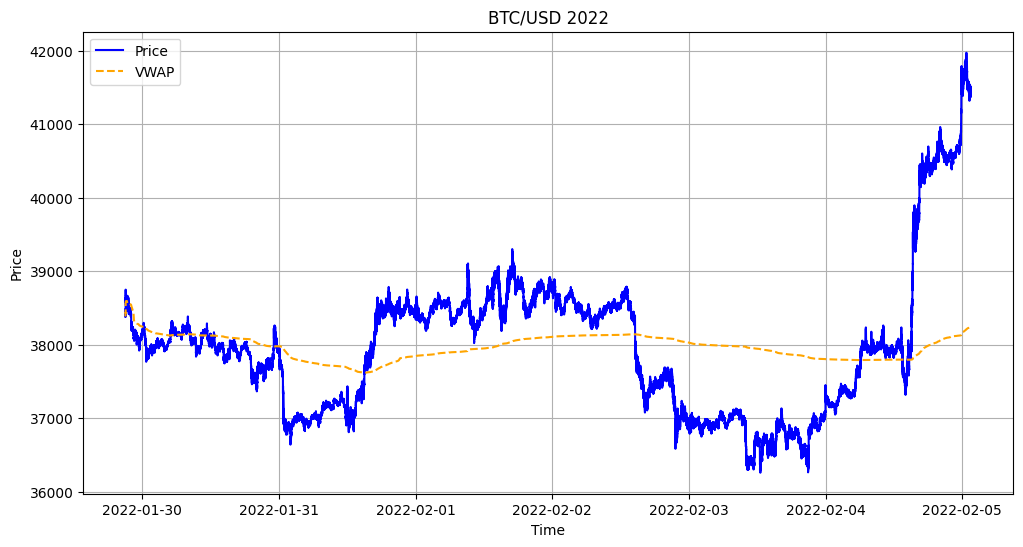

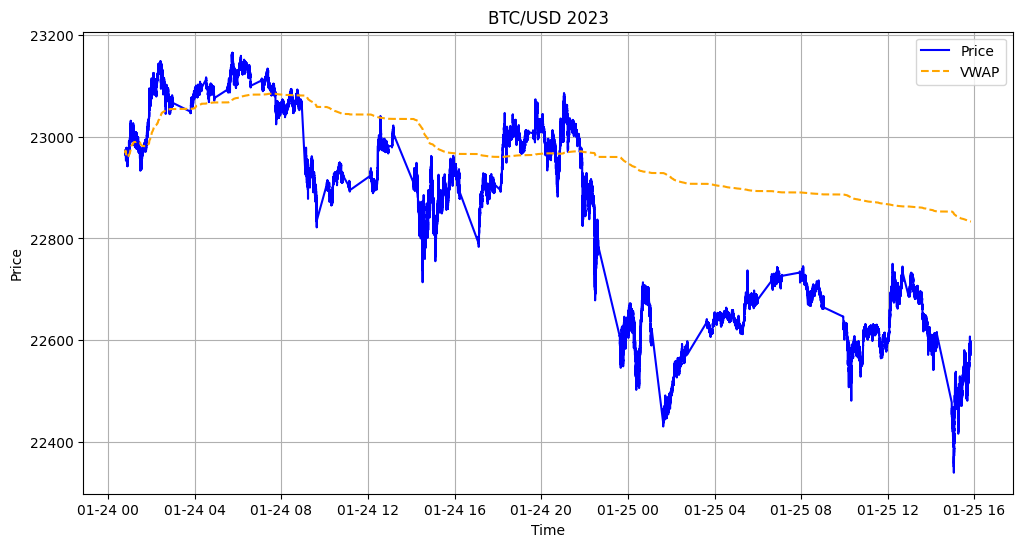

<Figure size 640x480 with 0 Axes>

In [69]:
def calculate_vwap(df):
    # Calculate VWAP
    df['vwap'] = (df['PriceMillionths'] * df['SizeBillionths']).cumsum() / df['SizeBillionths'].cumsum()
    return df

def plot_price_vwap(df, title):
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp_utc_nanoseconds_dt'], df['PriceMillionths'], label='Price', color='blue')
    plt.plot(df['timestamp_utc_nanoseconds_dt'], df['vwap'], label='VWAP', linestyle='--', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Rename dataframes
renamed_files = {
    'ETH_USD_trades_2022': 'ETH/USD 2022',
    'ETH_USD_trades_2023': 'ETH/USD 2023',
    'BTC_USD_trades_2022': 'BTC/USD 2022',
    'BTC_USD_trades_2023': 'BTC/USD 2023',
    'ETH_BTC_trades_2022': 'ETH/BTC 2022',
    'ETH_BTC_trades_2023': 'ETH/BTC 2023'
}

# Calculate VWAP and plot for each dataframe
for df_name, new_name in renamed_files.items():
    df = globals()[df_name]
    df = calculate_vwap(df)
    globals()[new_name] = df

# Plot BTC/USD 2022 and 2023 side by side
#plt.figure(figsize=(20, 10))

plot_price_vwap(globals()['BTC/USD 2022'], 'BTC/USD 2022')

plot_price_vwap(globals()['BTC/USD 2023'], 'BTC/USD 2023')

plt.tight_layout()
plt.show()



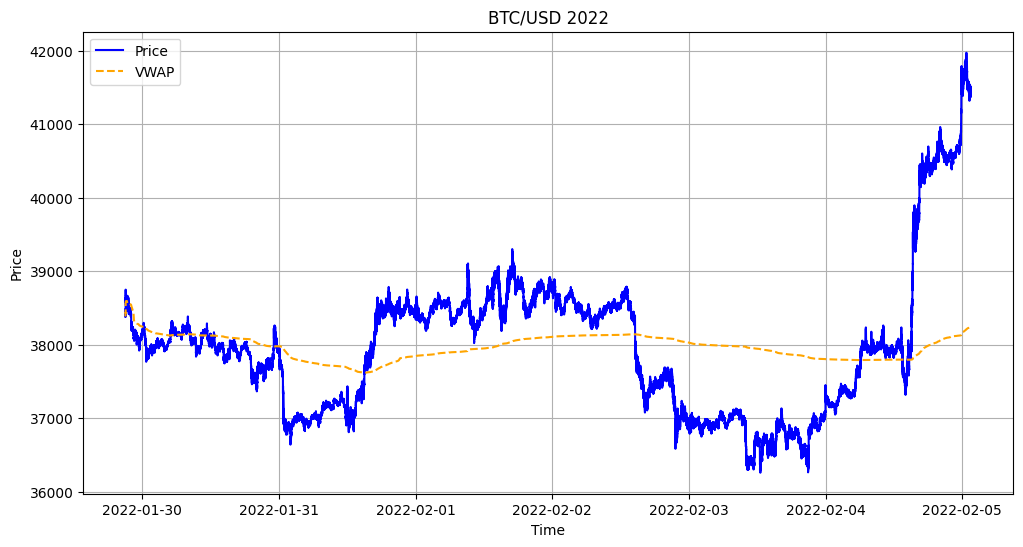

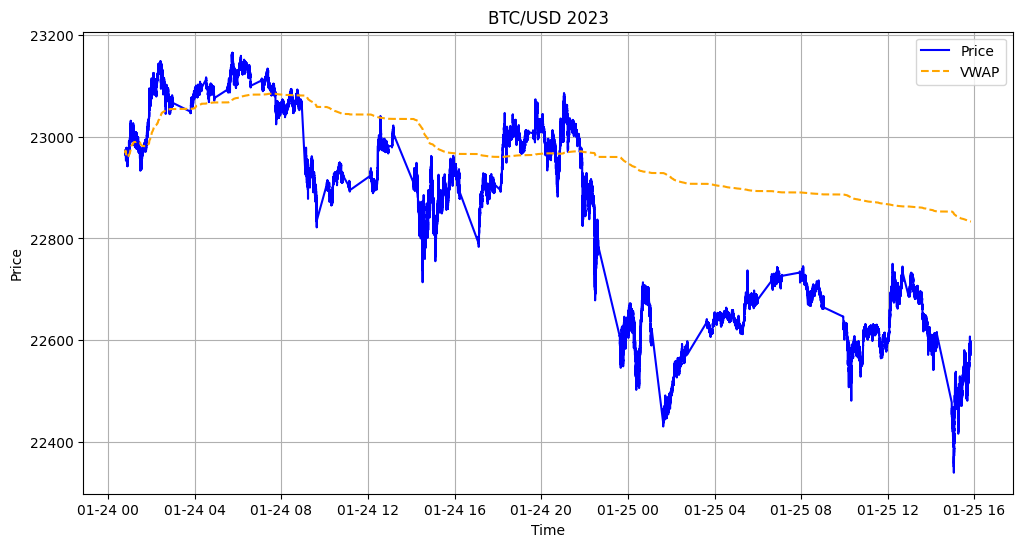

<Figure size 640x480 with 0 Axes>

In [70]:
# Plot BTC/USD 2022 and 2023 side by side
#plt.figure(figsize=(20, 10))

#plt.subplot(1, 2, 1)
plot_price_vwap(globals()['BTC/USD 2022'], 'BTC/USD 2022')

#plt.subplot(1, 2, 2)
plot_price_vwap(globals()['BTC/USD 2023'], 'BTC/USD 2023')

plt.tight_layout()
plt.show()

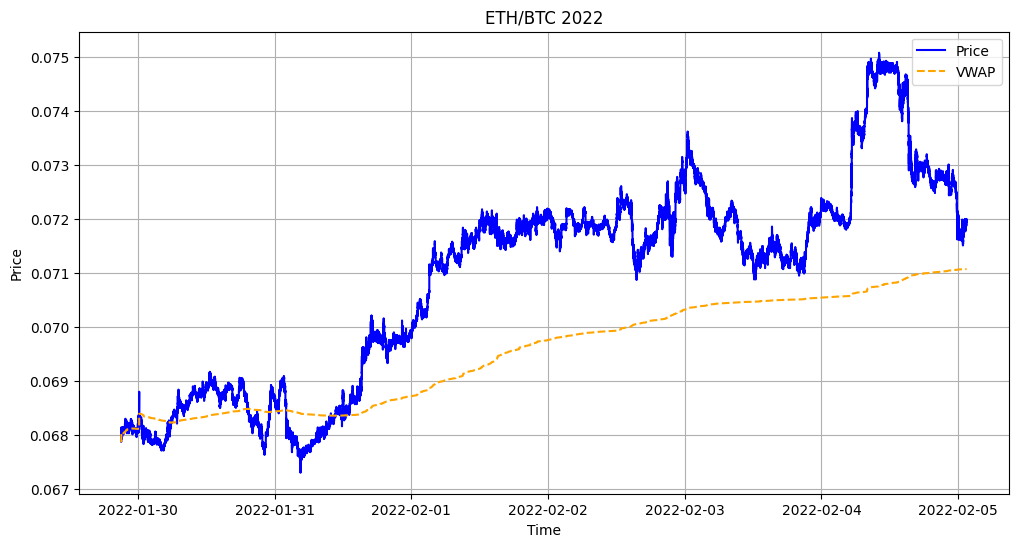

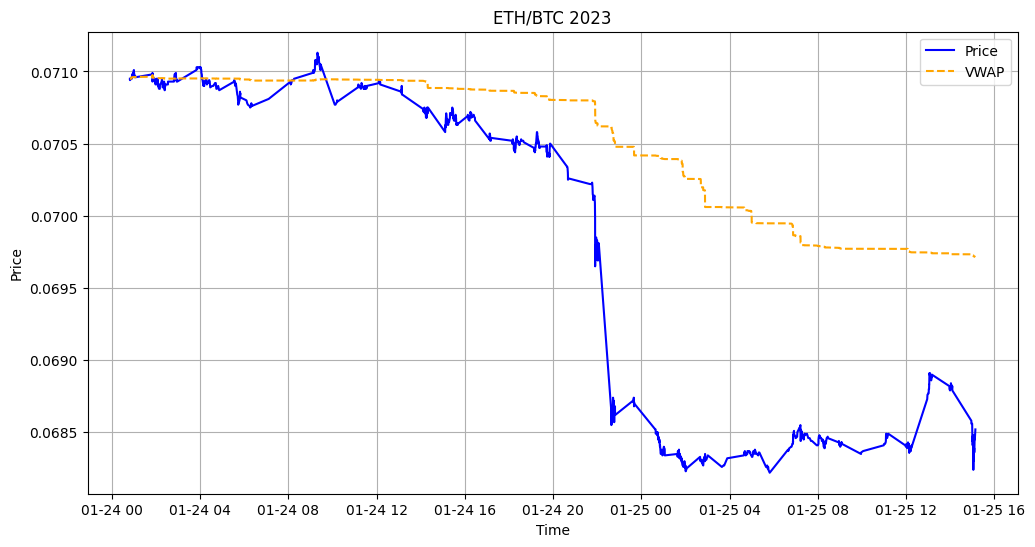

<Figure size 640x480 with 0 Axes>

In [71]:
# Plot ETH/BTC 2022 and 2023 side by side
#plt.figure(figsize=(20, 10))

#plt.subplot(1, 2, 1)
plot_price_vwap(globals()['ETH/BTC 2022'], 'ETH/BTC 2022')

#plt.subplot(1, 2, 2)
plot_price_vwap(globals()['ETH/BTC 2023'], 'ETH/BTC 2023')

plt.tight_layout()
plt.show()

### Volume Weighted Adjusted Price

The volume-weighted average price (VWAP) is a technical analysis indicator used on intraday charts that resets at the start of every new trading session. It's the average price a security has traded at throughout the day, based on both volume and price.

It is given by the cumulative typical price times the volume divided by the cumulative volume. The typical price is given by the average of high price, low price, and closing price. And cumulative refer to the total trades since the trading session openned. 

In [ ]:
def compute_target_quantity(
    df: pd.DataFrame,
    freq: str = '5Min',
    percentile: float = 0.65,
    fraction: float = 0.02
) -> float:
    """
    Given a trades DataFrame, compute a target quantity Q by:
      1) Resampling volumes in `freq` intervals (e.g. 5Min).
      2) Finding the chosen `percentile` (e.g. 65th percentile) 
         of these volumes.
      3) Taking `fraction` (e.g. 5%) of that volume 
         as the final Q.

    Returns Q as a float (in BTC).
    """
    
    # 1) Resample volumes: sum of BTC per freq
    volumes = (
        df.set_index('timestamp_utc_nanoseconds_dt')['SizeBillionths']
        .resample(freq)
        .sum()
        .dropna()
    )
    
    # 4) Compute the chosen percentile of these volumes
    vol_percentile = volumes.quantile(percentile)
    
    # 5) Q is a fraction of that percentile
    Q = fraction * vol_percentile
    
    return Q

def compute_minimum_threshold(
    df: pd.DataFrame,
    percentile: float = 0.05
) -> float:
    """
    Compute the trade-size threshold g as the given percentile
    of all trade sizes in the dataset.
    """
    
    return df['SizeBillionths'].quantile(percentile)

    
def filter_side(df: pd.DataFrame, Q: float) -> pd.DataFrame:
    """
    If Q>0 (we are buyers), filter trades where Side < 0 (aggressor is seller).
    If Q<0 (we are sellers), filter trades where Side > 0 (aggressor is buyer).
    """
    if Q > 0:
        return df[df['Side'] < 0].copy()
    else:
        return df[df['Side'] > 0].copy()

In [44]:
Q = compute_target_quantity(
    BTC_USD_trades_2022,
    freq='5Min',
    percentile=0.35,
    fraction=0.05
)

g = compute_minimum_threshold(BTC_USD_trades_2022, percentile=0.05)

p = 0.02  # 2%
# Adjust k for slippage or missed fills, but ensure it doesn't exceed 5%
k = min(p * 1.2, 0.05)

print("Computed Q:", Q, "BTC")
print("Minimum threshold g:", g, "BTC")

Computed Q: 1.3416871226250002 BTC
Minimum threshold g: 4.007e-05 BTC


In [ ]:
def vwap_participation_vectorized(
    df: pd.DataFrame,
    Q: float,
    p: float,
    g: float,
    pair: str = 'BTC-USD'
) -> pd.DataFrame:
    """
    Vectorized VWAP-like approach that:
      - Filters trades by side (depending on Q's sign).
      - Excludes trades below threshold g in 'SizeBillionths'.
      - Fills each trade with (size - g)*p up to total abs(Q).
      - Returns a DataFrame with fill_qty, partial/full flags, cost, fees, 
        cumulative fill, average fill price, fill duration, etc.
      - Ignores any pause logic (purely vectorized).
    """

    # Fee rate logic
    if '-USD' in pair.upper():
        fee_rate = 0.005  # 0.5% for BTC-USD (crypto-fiat)
    else:
        fee_rate = 0.001  # 0.1% for crypto-crypto

    # 1) Filter by side
    eligible = filter_side(df, Q)

    # 2) Create 'size'/'price' columns if needed
    eligible['size'] = eligible['SizeBillionths']
    eligible['price'] = eligible['PriceMillionths']

    # 3) Convert timestamps to datetime & sort
    eligible['datetime'] = pd.to_datetime(eligible['timestamp_utc_nanoseconds'], unit='ns')
    eligible.sort_values('datetime', inplace=True)

    # (Optional) time diffs in nanoseconds
    eligible['timestamp_diff_ns'] = eligible['timestamp_utc_nanoseconds'].diff().fillna(0).astype(int)

    # 4) Exclude trades below g => potential fill
    eligible_size = np.where(eligible['size'] > g, eligible['size'] - g, 0.0)
    potential_fill = eligible_size * p

    # 5) Vectorized cumsum to clip at abs(Q)
    csum = potential_fill.cumsum()
    target_abs = abs(Q)
    idx_over = csum.searchsorted(target_abs, side='right')
    final_fill = potential_fill.copy()

    if idx_over < len(final_fill):
        if idx_over == 0:
            # first row alone exceeds Q
            final_fill[0] = target_abs
            final_fill[1:] = 0.0
        else:
            csum_before = csum[idx_over - 1] if (idx_over - 1) >= 0 else 0.0
            needed = target_abs - csum_before
            final_fill[idx_over] = min(final_fill[idx_over], needed)
            if idx_over + 1 < len(final_fill):
                final_fill[idx_over + 1:] = 0.0

    # signed fill
    signed_fill = final_fill * (1.0 if Q > 0 else -1.0)
    eligible['fill_qty'] = signed_fill

    # partial vs. full vs. none
    partial_mask = (final_fill < potential_fill) & (final_fill > 0.0)
    fill_type = np.where(final_fill > 0, 
                         np.where(partial_mask, "partial", "full"), 
                         "none")
    eligible['fill_type'] = fill_type

    # cumulative fill
    csum_final = eligible['fill_qty'].cumsum()
    eligible['cumulative_fill'] = csum_final

    # Q_remaining_before / after
    csum_shifted = np.roll(csum_final, 1)
    csum_shifted[0] = 0.0
    Q_before = Q - csum_shifted
    Q_after  = Q - csum_final
    eligible['Q_remaining_before'] = Q_before
    eligible['Q_remaining_after']  = Q_after

    # cost + fee
    row_cost = eligible['fill_qty'] * eligible['price']
    row_fee  = np.abs(row_cost) * fee_rate
    eligible['cost_usd'] = row_cost
    eligible['fee_usd']  = row_fee

    # Summaries
    total_filled = eligible['fill_qty'].sum()
    cost_usd = eligible['cost_usd'].sum()
    total_fees = eligible['fee_usd'].sum()
    filled_trades_count = (eligible['fill_qty'] != 0).sum()

    # fill duration
    fill_rows = eligible[eligible['fill_qty'] != 0]
    if len(fill_rows) > 0:
        first_fill_time = fill_rows.iloc[0]['datetime']
        last_fill_time  = fill_rows.iloc[-1]['datetime']
        fill_duration   = (last_fill_time - first_fill_time).total_seconds()
    else:
        first_fill_time = pd.NaT
        last_fill_time  = pd.NaT
        fill_duration   = 0

    # average fill price
    if total_filled == 0:
        vwap_price = np.nan
    else:
        vwap_price = cost_usd / total_filled

    # store them in the DataFrame so we can see them in every row if we want
    eligible['avg_fill_price'] = vwap_price
    eligible['fill_duration_seconds'] = fill_duration

    # Print summary
    print("----------- VWAP Participation Results (Vectorized) -----------")
    print(f"Pair: {pair}")
    print(f"Fee rate = {fee_rate:.2%}")
    print(f"Target Q = {Q:.4f} (abs={target_abs:.4f})   p = {p:.2%}, threshold g = {g:.2f}")
    print(f"Total filled = {total_filled:.4f}")
    if not np.isnan(vwap_price):
        print(f"VWAP Price (USD per BTC) = {vwap_price:.4f}")
        print(f"Total Cost (USD) = {cost_usd:.4f}")
    print(f"Total fees (USD) = {total_fees:.4f}")
    print(f"Filled trades count = {filled_trades_count}")
    print(f"Time to fill (seconds) = {fill_duration:.2f}")
    print("--------------------------------------------------------------\n")

    return eligible

def simulate_vwap_in_time_windows(
    df: pd.DataFrame,
    Q: float,
    p: float,
    g: float,
    window: str = '15Min',
    pair: str = 'BTC-USD'
) -> pd.DataFrame:
    """
    Break the data into time windows (e.g., 15Min). For each window:
      - Determine the arrival price (the first trade's price in that window).
      - Run vwap_participation_vectorized with Q, p, g in that subset.
      - Attach 'arrival_price' to all rows in the result.
      - Return a single DataFrame with all windows concatenated.

    NOTE: Each window is an independent simulation. 
          We do NOT carry Q_remaining from one window to the next.
    """
    # 1) Ensure we have a 'datetime' index for grouping by time
    if 'datetime' not in df.columns:
        df = df.copy()
        df['datetime'] = pd.to_datetime(df['timestamp_utc_nanoseconds'], unit='ns')
    df = df.set_index('datetime').sort_index()

    # 2) For each time window, run the vectorized approach
    results_list = []

    # groupby with pd.Grouper to create e.g. 15-minute windows
    for win_start_time, group_df in df.groupby(pd.Grouper(freq=window)):
        if len(group_df) == 0:
            continue

        # reset index to have 'datetime' as a column
        group_df = group_df.reset_index(drop=False)
        group_df.sort_values('datetime', inplace=True)

        # 2a) arrival price = price of the first trade in that window
        #     (the user has PriceMillionths column, so let's read from that)
        arrival_price = None
        first_row = group_df.iloc[0]
        arrival_price = first_row['PriceMillionths']

        # 2b) Run the VWAP simulation
        window_result = vwap_participation_vectorized(
            df=group_df,
            Q=Q,
            p=p,
            g=g,
            pair=pair
        )

        # 2c) Add arrival_price to all rows in this window
        window_result['arrival_price'] = arrival_price
        window_result['window_start_time'] = win_start_time

        # 2d) Append to list
        results_list.append(window_result)

    # 3) Concatenate all window results
    if len(results_list) > 0:
        all_results_df = pd.concat(results_list, ignore_index=True)
    else:
        all_results_df = pd.DataFrame()

    return all_results_df


In [52]:
# Example usage:
results_df = vwap_participation_vectorized(
    df=BTC_USD_trades_2022,  # your DataFrame with the specified columns
    Q=Q,           # want to buy 10 BTC
    p=0.02,           # 2% participation rate
    g=g,      # min threshold in the same "SizeBillionths" scale
    pair='BTC-USD'    # fee logic
)

----------- VWAP Participation Results (Vectorized) -----------
Pair: BTC-USD
Fee rate = 0.50%
Target Q = 1.3417 (abs=1.3417)   p = 2.00%, threshold g = 0.00
Total filled = 1.3417
VWAP Price (USD per BTC) = 38591.7387
Total Cost (USD) = 51778.0388
Total fees (USD) = 258.8902
Filled trades count = 1973
Time to fill (seconds) = 452.61
--------------------------------------------------------------



In [58]:
# Example usage:
all_results_df = simulate_vwap_in_time_windows(
    df=BTC_USD_trades_2022,  # your DataFrame with the specified columns
    Q=Q,           # want to buy 10 BTC
    p=0.02,           # 2% participation rate
    g=g,      # min threshold in the same "SizeBillionths" scale
    window='15Min',  # time window for each simulation
    pair='BTC-USD'    # fee logic
)

----------- VWAP Participation Results (Vectorized) -----------
Pair: BTC-USD
Fee rate = 0.50%
Target Q = 1.3417 (abs=1.3417)   p = 2.00%, threshold g = 0.00
Total filled = 1.3417
VWAP Price (USD per BTC) = 38591.7387
Total Cost (USD) = 51778.0388
Total fees (USD) = 258.8902
Filled trades count = 1973
Time to fill (seconds) = 452.61
--------------------------------------------------------------

----------- VWAP Participation Results (Vectorized) -----------
Pair: BTC-USD
Fee rate = 0.50%
Target Q = 1.3417 (abs=1.3417)   p = 2.00%, threshold g = 0.00
Total filled = 1.2246
VWAP Price (USD per BTC) = 38587.6115
Total Cost (USD) = 47254.0375
Total fees (USD) = 236.2702
Filled trades count = 2099
Time to fill (seconds) = 898.40
--------------------------------------------------------------

----------- VWAP Participation Results (Vectorized) -----------
Pair: BTC-USD
Fee rate = 0.50%
Target Q = 1.3417 (abs=1.3417)   p = 2.00%, threshold g = 0.00
Total filled = 1.3417
VWAP Price (USD per BT

In [60]:
summary_by_window = (
    all_results_df
    .groupby('window_start_time')
    .agg({
       'fill_qty':'sum',
       'cost_usd':'sum',
       'fee_usd':'sum',
       'arrival_price':'first',  # The arrival price was constant in each window
       'avg_fill_price':'mean',  # It's the same within a single window, but we can do 'first'
    })
)

In [61]:
summary_by_window

,fill_qty,cost_usd,fee_usd,arrival_price,avg_fill_price
window_start_time,,,,,
2022-01-29 21:00:00,1.34169,51778.03882,258.89019,38383.38000,38591.73867
2022-01-29 21:15:00,1.22459,47254.03749,236.27019,38587.70000,38587.61151
2022-01-29 21:30:00,1.34169,51685.99083,258.42995,38579.91000,38523.13252
2022-01-29 21:45:00,0.70215,27003.64635,135.01823,38426.92000,38458.61405
2022-01-29 22:00:00,1.34169,51347.07295,256.73536,38383.97000,38270.52678
...,...,...,...,...,...
2022-02-05 00:15:00,1.34169,55872.55724,279.36279,41723.52000,41643.50712
2022-02-05 00:30:00,1.34169,55872.53427,279.36267,41650.46000,41643.49000
2022-02-05 00:45:00,1.34169,55958.07655,279.79038,41742.21000,41707.24724


In [9]:
# ============================================================================
# 2) Choose your simulation parameters
# ============================================================================
Q = 1e9        # Example: we want to buy 1 BTC (if "billionths" means 1 BTC=1e9). 
#   If we wanted to SELL, we'd set Q negative (e.g., Q = -1e9)

tau_s = 1674521267874527000  # Example: any arrival time in nanoseconds
p = 0.01                     # 1% target participation
pause_seconds = 0.5          # Pause 0.5s after each fill flurry

# If your timestamps are in nanoseconds, we convert pause_seconds -> nanoseconds:
pause_ns = int(pause_seconds * 1e9)

# ============================================================================
# 3) Compute or define the parameter 'k'
#    We pick k slightly bigger than p, capped at 5%
# ============================================================================
k = min(p + 0.01, 0.05)

# ============================================================================
# 4) Compute the minimum size threshold 'g'
#    => the 5th percentile of trade sizes in BTC_USD_trades_2023
# ============================================================================
all_sizes = BTC_USD_trades_2023["SizeBillionths"].astype(float)
g = np.percentile(all_sizes, 5)  # the 5th percentile


In [11]:
g

16460.0

In [ ]:
# ============================================================================
# 2) Choose your simulation parameters
# ============================================================================
Q = 1e9        # Example: we want to buy 1 BTC (if "billionths" means 1 BTC=1e9). 
#   If we wanted to SELL, we'd set Q negative (e.g., Q = -1e9)

tau_s = 1674521267874527000  # Example: any arrival time in nanoseconds
p = 0.01                     # 1% target participation
pause_seconds = 0.5          # Pause 0.5s after each fill flurry

# If your timestamps are in nanoseconds, we convert pause_seconds -> nanoseconds:
pause_ns = int(pause_seconds * 1e9)

# ============================================================================
# 3) Compute or define the parameter 'k'
#    We pick k slightly bigger than p, capped at 5%
# ============================================================================
k = min(p + 0.01, 0.05)

# ============================================================================
# 4) Compute the minimum size threshold 'g'
#    => the 5th percentile of trade sizes in BTC_USD_trades_2023
# ============================================================================
all_sizes = BTC_USD_trades_2023["SizeBillionths"].astype(float)
g = np.percentile(all_sizes, 5)  # the 5th percentile

# ============================================================================
# 5) Filter trades that occur after tau_s and have the correct "Side"
#    - If Q>0 (buying), we only participate in trades with Side < 0 
#      (someone is aggressively selling).
#    - If Q<0 (selling), we only participate in trades with Side > 0.
# ============================================================================
if Q > 0:
    side_needed = -1
else:
    side_needed = 1

trades_df = BTC_USD_trades_2023.loc[
    (BTC_USD_trades_2023["timestamp_utc_nanoseconds"] >= tau_s) &
    (BTC_USD_trades_2023["Side"] == side_needed)
].copy()

# Convert to float for convenience
trades_df["trade_size"] = trades_df["SizeBillionths"].astype(float)
trades_df["trade_price"] = trades_df["PriceMillionths"].astype(float)

# Sort by timestamp, then by price
trades_df.sort_values(["timestamp_utc_nanoseconds", "trade_price"], inplace=True)
trades_df.reset_index(drop=True, inplace=True)

# ============================================================================
# 6) Group by (timestamp, price) to sum up total quantities at each price level
# ============================================================================
grouped = trades_df.groupby(
    ["timestamp_utc_nanoseconds", "trade_price"], as_index=False
)["trade_size"].sum()

grouped.rename(columns={"trade_size": "q_level"}, inplace=True)
grouped.sort_values(["timestamp_utc_nanoseconds", "trade_price"], inplace=True)
grouped.reset_index(drop=True, inplace=True)

# ============================================================================
# 7) Now we run the discrete-event simulation.
#    We'll accumulate until we reach |Q| (the absolute target).
# ============================================================================
accumulated_quantity = 0.0  # track how much we have bought/sold so far
weighted_price_sum = 0.0    # for VWAP calculation
total_fees_paid = 0.0

fill_details = []           # store fill events if we like
next_earliest_time = tau_s
target_abs = abs(Q)

# Decide fee (just assume crypto-fiat => 50 bps = 0.005)
fee_rate = 50.0 / 10000.0   # = 0.005

i = 0
n = len(grouped)

while i < n and accumulated_quantity < target_abs:
    row = grouped.iloc[i]
    this_timestamp = row["timestamp_utc_nanoseconds"]
    
    # If we haven't reached the next allowed time, skip
    if this_timestamp < next_earliest_time:
        i += 1
        continue
    
    # Collect all rows with same timestamp => "flurry" of trades
    same_timestamp_rows = []
    time0 = this_timestamp
    
    j = i
    while j < n and grouped.iloc[j]["timestamp_utc_nanoseconds"] == time0:
        same_timestamp_rows.append(grouped.iloc[j])
        j += 1
    
    # Process this flurry at time0
    flurry_fill_qty = 0.0
    flurry_notional = 0.0
    
    for rec in same_timestamp_rows:
        q_lvl = rec["q_level"]
        lvl_price = rec["trade_price"]
        
        # s = max(0, (q_lvl - g) * k)
        s = max(0.0, (q_lvl - g) * k)
        
        # clamp if near the end of target
        remain = target_abs - accumulated_quantity
        if s > remain:
            s = remain
        
        if s <= 0:
            continue
        
        # Convert price from millionths -> real
        real_price = lvl_price / 1e6
        # Convert size from "billionths" -> real
        real_size = s / 1e9
        
        notional = real_price * real_size
        
        # Update fill stats
        flurry_fill_qty += s
        flurry_notional += notional
        
        fill_details.append({
            "fill_timestamp": time0,
            "price_millionths": lvl_price,
            "fill_size_billionths": s,
            "real_price": real_price,
            "real_size": real_size,
            "notional": notional
        })
        
        accumulated_quantity += s
        if accumulated_quantity >= target_abs:
            break
    
    # If we participated in that timestamp, we set a new pause
    if flurry_fill_qty > 0:
        # Weighted price sum for VWAP: note that flurry_fill_qty is in "billionths"
        # so we do flurry_notional / (filled_in_BTC) 
        # => We'll store the sum in real-dollar terms to finalize after loop
        weighted_price_sum += flurry_notional
        
        # Fees (in real currency terms, e.g. USD)
        total_fees_paid += flurry_notional * fee_rate
        
        # Pause
        next_earliest_time = time0 + pause_ns
    
    # Move to next group index
    i = j

# ============================================================================
# 8) Compute final stats
# ============================================================================
filled = accumulated_quantity
if filled > 0:
    # Because 'filled' is in "billionths", the actual number of BTC is filled / 1e9
    # Weighted average price = total notional / total units
    # => total units in "real" = (accumulated_quantity / 1e9)
    vwap_price = weighted_price_sum / (filled / 1e9)
else:
    vwap_price = 0.0

results_summary = {
    "TargetQ": Q,
    "Filled_billionths": filled,
    "Filled_in_BTC": filled / 1e9,
    "VWAP_Price_USD": vwap_price,
    "Total_Fees_USD": total_fees_paid,
    "Used_k": k,
    "g_threshold_billionths": g
}

# ============================================================================
# 9) Print or inspect the summary
# ============================================================================
print("=== Simulation Summary ===")
for key, val in results_summary.items():
    print(f"{key}: {val}")

# Convert fill_details to a DataFrame if you want to analyze or export it
fill_details_df = pd.DataFrame(fill_details)
print("\n=== Fill Details (head) ===")
print(fill_details_df.head(10))


In [14]:
def compute_vwap_passive_fill(
    trades_df: pd.DataFrame,
    Q: float,
    tau_s: int,
    p: float,
    pause_seconds: float,
    fee_bps_fiat: float = 50.0,
    fee_bps_crypto: float = 10.0,
    assume_fiat_fee: bool = True,
    timestamp_col: str = "timestamp_utc_nanoseconds",
    side_col: str = "Side",
    price_col: str = "PriceMillionths",
    size_col: str = "SizeBillionths"
):
    """
    Simulates a simplified post-only VWAP-style participation fill.
    
    Parameters
    ----------
    trades_df : pd.DataFrame
        DataFrame of trades, containing at least:
          - timestamp_col (nanoseconds or other time unit)
          - side_col (+1 or -1 indicating which side was aggressive)
          - price_col (integer price in millionths)
          - size_col (integer size in billionths)
    Q : float
        Target quantity to buy (Q>0) or sell (Q<0).
    tau_s : int
        Start time (in nanoseconds, or whichever time unit used by `timestamp_col`).
    p : float
        Target participation rate (between 0 and 0.05 typically).
    pause_seconds : float
        The pause duration after each fill event (in *seconds*).
        If your timestamps are in nanoseconds, you'll need to convert seconds.
    fee_bps_fiat : float
        The basis-points fee for crypto-fiat trades (default 50 bps = 0.5%).
    fee_bps_crypto : float
        The basis-points fee for crypto-crypto trades (default 10 bps = 0.1%).
    assume_fiat_fee : bool
        If True, always apply the `fee_bps_fiat` rate. If False, always apply `fee_bps_crypto`.
        (You can enhance logic to pick based on actual pair.)
    timestamp_col : str
        The column name for trade timestamps in `trades_df`.
    side_col : str
        The column name indicating the sign of aggressive side: +1 or -1.
    price_col : str
        The column name for price.
    size_col : str
        The column name for traded quantity.
        
    Returns
    -------
    results : dict
        Contains summary information about how much was filled, the average price, fees, etc.
    fill_details : pd.DataFrame
        (Optional) DataFrame of each “fill event” with columns for timestamp, filled quantity, fill price, etc.
    """
    
    # -------------------------
    # 1. Define or compute k > p, but capped at 5%
    #    For simplicity: let k = min(p + 0.01, 0.05). 
    #    You can set your own logic here.
    # -------------------------
    k = min(p + 0.01, 0.05)
    
    # ----------------------------------------------------------------
    # 2. Compute the minimum size threshold g = 5th percentile of all
    #    trades' sizes in the *entire* trades_df (or some subset).
    # ----------------------------------------------------------------
    all_sizes = trades_df[size_col].astype(float)
    g = np.percentile(all_sizes, 5)  # 5th percentile
    
    # ----------------------------------------------------------------
    # 3. Filter trades from start time onward and side matching Q.
    #    - If Q>0 (buying), "available" trades are the ones with Side < 0
    #      (someone aggressively sold into us).
    #    - If Q<0 (selling), "available" trades are the ones with Side > 0.
    # ----------------------------------------------------------------
    if Q > 0:
        side_needed = -1
    else:
        side_needed = 1
    
    # Note: convert `pause_seconds` into the same time units as trades_df[timestamp_col], if needed.
    # If trades_df uses nanoseconds, then:
    pause_ns = int(pause_seconds * 1e9)  # from seconds to nanoseconds
    
    # Filter by time & side
    df = trades_df.loc[
        (trades_df[timestamp_col] >= tau_s) &
        (trades_df[side_col] == side_needed)
    ].copy()
    
    # Convert size to float for convenience; might remain int if you prefer
    df["trade_size"] = df[size_col].astype(float)
    df["trade_price"] = df[price_col].astype(float)
    
    # Sort by timestamp ascending, then possibly by price if you want to consider levels
    df.sort_values(by=[timestamp_col, price_col], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # ----------------------------------------------------------------
    # 4. Group by [timestamp, price] so we can compute q_level
    # ----------------------------------------------------------------
    grouped = df.groupby([timestamp_col, price_col], as_index=False)["trade_size"].sum()
    grouped.rename(columns={"trade_size": "q_level"}, inplace=True)
    
    # We will iterate through these grouped records in chronological order
    grouped.sort_values(by=[timestamp_col, price_col], inplace=True)
    grouped.reset_index(drop=True, inplace=True)

    # ----------------------------------------------------------------
    # 5. Simulation (discrete-event) to respect “pause” after each flurry
    # ----------------------------------------------------------------
    
    accumulated_quantity = 0.0
    weighted_price_sum = 0.0  # for VWAP calculation
    total_fees_paid = 0.0
    
    fill_rows = []  # to store fill events if you want a breakdown
    next_earliest_time = tau_s  # we can't fill again until at least this time
    
    i = 0
    n = len(grouped)
    
    # Decide which fee rate to apply (bp -> fraction)
    if assume_fiat_fee:
        fee_rate = fee_bps_fiat / 10000.0   # e.g., 50 bps = 0.005
    else:
        fee_rate = fee_bps_crypto / 10000.0 # e.g., 10 bps = 0.001
    
    # Because Q can be negative, but we will track absolute fill
    target_abs = abs(Q)
    
    while i < n and accumulated_quantity < target_abs:
        row = grouped.iloc[i]
        tstamp = row[timestamp_col]
        lvl_price = row[price_col]
        q_lvl = row["q_level"]  # total quantity at that (timestamp, price)
        
        if tstamp < next_earliest_time:
            # We are still in the "pause" window. Skip this group.
            i += 1
            continue
        
        # ----------------------------------------------------------------
        # For this single timestamp, we might have multiple "levels" 
        # if the order flow traded through multiple price points. 
        # So gather all rows with the same timestamp before we "pause".
        # ----------------------------------------------------------------
        same_time_records = []
        time0 = tstamp
        
        # We'll accumulate from `i` onward while timestamp matches `time0`
        j = i
        while j < n and grouped.iloc[j][timestamp_col] == time0:
            same_time_records.append(grouped.iloc[j])
            j += 1
        
        # Now we have all price levels that occurred simultaneously at time0
        # Each record has columns: [timestamp_utc_nanoseconds, price, q_level]
        
        # "Flurry" fill logic:
        #  s = max(0, (q_level - g) * k)
        #  sum up the total across all levels
        flurry_fill_qty = 0.0
        flurry_notional = 0.0
        
        for record in same_time_records:
            q_lvl_here = record["q_level"]
            lvl_price_here = record[price_col]
            
            # 1) Compute the partial fill using formula s = max(0, (q_lvl_here - g) * k).
            #    Because we want to avoid negative results if q_lvl_here < g.
            s_here = max(0.0, (q_lvl_here - g) * k)
            
            # 2) Possibly clamp s_here if it would exceed what's left of target_abs.
            #    i.e., if we are near the end of our total Q.
            fill_remaining = target_abs - accumulated_quantity
            s_here = min(s_here, fill_remaining)
            
            if s_here <= 0:
                continue
            
            # 3) Notional fill = s_here * lvl_price_here (in appropriate units).
            #    Because price is in "millionths" and size in "billionths",
            #    you might want to scale them to “full” units. E.g.:
            #         real_price = lvl_price_here / 1e6
            #         real_size  = s_here / 1e9
            real_price = lvl_price_here / 1e6
            real_size  = s_here / 1e9
            notional_here = real_price * real_size
            
            # 4) Collect for weighted average price
            flurry_fill_qty += s_here
            flurry_notional += notional_here
            
            # Save an entry if you want more detail
            fill_rows.append({
                "fill_timestamp": time0,
                "fill_price_millionths": lvl_price_here,
                "fill_size_billionths": s_here,
                "real_price": real_price,
                "real_size": real_size,
                "notional": notional_here
            })
            
            # Check if we fully reached target
            accumulated_quantity += s_here
            if accumulated_quantity >= target_abs:
                break
        
        # Summarize flurry
        if flurry_fill_qty > 0:
            # Weighted price contribution
            weighted_price_sum += flurry_notional
            # Fees
            #   Because we used "notional_here" in real units,
            #   fee = notional_here * fee_rate
            #   Summed across the entire flurry:
            total_fees_paid += flurry_notional * fee_rate
            
            # Pause after this time
            next_earliest_time = time0 + pause_ns
        
        i = j  # skip all those same-time records
        
    # After loop, compute final stats
    final_filled = accumulated_quantity
    if final_filled > 0:
        vwap_price = weighted_price_sum / (final_filled / 1e9)  # because final_filled is in "billionths"
    else:
        vwap_price = 0.0
    
    results_summary = {
        "TargetQ": Q,
        "Filled": final_filled,
        "VWAP_price": vwap_price,
        "Total_Notional": weighted_price_sum,
        "Total_Fees": total_fees_paid,
        "Used_k": k,
        "g_threshold": g,
    }
    
    fill_details = pd.DataFrame(fill_rows)
    
    return results_summary, fill_details


In [17]:
Q = 0.15
tau_s = 1686000000000000000 # 2023-06-06 00:00:00
p = 0.03
pause_seconds = 1e-3

summary, details = compute_vwap_passive_fill(
    BTC_USD_trades_2023,
    Q=Q,
    tau_s=tau_s,
    p=p,
    pause_seconds=pause_seconds,
    assume_fiat_fee=True  # apply 50bps
)
    

In [ ]:
# ------------------------------------------------------------------
# EXAMPLE USAGE
# ------------------------------------------------------------------
if __name__ == "__main__":
    # Suppose you already have loaded your data into BTC_USD_trades_2023 DataFrame
    # with columns ["received_utc_nanoseconds", "timestamp_utc_nanoseconds", 
    #               "PriceMillionths", "SizeBillionths", "Side", ...]
    #
    # For demonstration, let's create a small dummy dataset:

    data = {
        "timestamp_utc_nanoseconds": [
            1674521267874527000, 1674521267874527000, 1674521267878712000,
            1674521267886114000, 1674521268676444000
        ],
        "PriceMillionths": [22970120000, 22970150000, 22970120000, 22969160000, 22969840000],
        "SizeBillionths":  [87069600,    25797600,    10,         217683140,   10000000],
        "Side":           [-1,          -1,          -1,          -1,          +1]
    }
    trades_df = pd.DataFrame(data)

    # Let’s pick Q= 1e9 (i.e. "1 BTC" if your size is in billionths),
    # start time = earliest trade timestamp,
    # target participation rate p= 0.01 (1%),
    # pause 0.5 seconds
    Q = 1e9       # 1 BTC in "billionths"
    tau_s = trades_df["timestamp_utc_nanoseconds"].min()
    p = 0.01
    pause_seconds = 0.5
    
    # Run the simulation
    summary, details = compute_vwap_passive_fill(
        trades_df,
        Q=Q,
        tau_s=tau_s,
        p=p,
        pause_seconds=pause_seconds,
        assume_fiat_fee=True  # apply 50bps
    )
    
    print("=== Simulation Summary ===")
    for k,v in summary.items():
        print(f"{k}: {v}")
    
    print("\n=== Fill Details ===")
    print(details)
